In [1]:
import os, random, glob, pickle, collections, math
import numpy as np
import pandas as pd
import ujson as json
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline 

from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import GlobalAveragePooling2D, Flatten, Dropout, Dense, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.preprocessing import image
from keras import backend as K
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [2]:
# TRAIN_DIR = '../data/train/'
TEST_DIR = '../RFCN/JPEGImages/'
RFCN_MODEL = 'resnet101_rfcn_ohem_iter_30000'
CROP_MODEL = 'resnet50_DO5_FT38_Hybrid_CW'
if not os.path.exists('./' + CROP_MODEL):
    os.mkdir('./' + CROP_MODEL)
CHECKPOINT_DIR = './' + CROP_MODEL + '/checkpoint/'
if not os.path.exists(CHECKPOINT_DIR):
    os.mkdir(CHECKPOINT_DIR)
LOG_DIR = './' + CROP_MODEL + '/log/'
if not os.path.exists(LOG_DIR):
    os.mkdir(LOG_DIR)
OUTPUT_DIR = './' + CROP_MODEL + '/output/'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
CROP_CLASSES=FISH_CLASSES[:]
CROP_CLASSES.remove('NoF')
CONF_THRESH = 0.8
ROWS = 224
COLS = 224
BATCHSIZE = 128
LEARNINGRATE = 1e-4
BG_THRESH_HI = 0.3
BG_THRESH_LO = 0.1
# like RCNN expand the crop by 16 pixels
p=0

def load_img(path, bbox, target_size=None):
    img = Image.open(path)
    img = img.convert('RGB')
    cropped = img.crop((bbox[0],bbox[1],bbox[2],bbox[3]))
    if target_size:
        cropped = cropped.resize((target_size[1], target_size[0]))
    return cropped

def preprocess_input(x):
    #resnet50 image preprocessing
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

def get_best_model():
    files = glob.glob(CHECKPOINT_DIR+'*')
    val_losses = [float(f.split('-')[-1][:-5]) for f in files]
    index = val_losses.index(min(val_losses))
    print('Loading model from checkpoint file ' + files[index])
    model = load_model(files[index])
    model_name = files[index].split('/')[-1]
    return (model, model_name)

In [3]:
# GTbbox_df = ['image_file','crop_index','crop_class','xmin',''ymin','xmax','ymax']

file_name = 'GTbbox_df.pickle'
if os.path.exists(OUTPUT_DIR+file_name):
    print ('Loading from file '+file_name)
    GTbbox_df = pd.read_pickle(OUTPUT_DIR+file_name)
else:
    print ('Generating file '+file_name)       
    GTbbox_df = pd.DataFrame(columns=['image_file','crop_index','crop_class','xmin','ymin','xmax','ymax'])  

    crop_classes=FISH_CLASSES[:]
    crop_classes.remove('NoF')
    
    for c in crop_classes:
        print(c)
        j = json.load(open('../data/BBannotations/{}.json'.format(c), 'r'))
        for l in j: 
            filename = l["filename"]
            head, image_file = os.path.split(filename)
            basename, file_extension = os.path.splitext(image_file) 
            image = Image.open(TEST_DIR+'/'+image_file)
            width_image, height_image = image.size
            for i in range(len(l["annotations"])):
                a = l["annotations"][i]
                xmin = (a["x"])
                ymin = (a["y"])
                width = (a["width"])
                height = (a["height"])
                delta_width = p/(COLS-2*p)*width
                delta_height = p/(ROWS-2*p)*height
                xmin_expand = xmin-delta_width
                ymin_expand = ymin-delta_height
                xmax_expand = xmin+width+delta_width
                ymax_expand = ymin+height+delta_height
                assert max(xmin_expand,0)<min(xmax_expand,width_image)
                assert max(ymin_expand,0)<min(ymax_expand,height_image)
                GTbbox_df.loc[len(GTbbox_df)]=[image_file,i,a["class"],max(xmin_expand,0),max(ymin_expand,0),min(xmax_expand,width_image),min(ymax_expand,height_image)]
                if a["class"] != c: print(GTbbox_df.tail(1))                   
  
    GTbbox_df.to_pickle(OUTPUT_DIR+file_name)  

Loading from file GTbbox_df.pickle


In [4]:
#class weight = n_samples / (n_classes * np.bincount(y))
class_weight_fish = dict(GTbbox_df.groupby('crop_class').size())
class_weight = {}
n_samples = GTbbox_df.shape[0]
for key,value in class_weight_fish.items():
        class_weight[CROP_CLASSES.index(key)] = n_samples / (len(CROP_CLASSES)*value)
class_weight

{0: 0.24847933602410324,
 1: 2.0406162464985993,
 2: 4.9557823129251704,
 3: 5.9469387755102039,
 4: 1.8751608751608753,
 5: 3.3038548752834469,
 6: 0.78151260504201681}

In [ ]:
# class_weight = dict(GTbbox_df.groupby('crop_class').size())
# ref = max(class_weight.values())
# for key,value in class_weight.items():
#     class_weight[key] = ref/value
# class_weight

In [14]:
%%time
# train data prepare
# GTbbox_df = ['image_file','crop_index','crop_class','xmin',''ymin','xmax','ymax']

train_df, valid_df = train_test_split(GTbbox_df, test_size=0.2, random_state=1986, stratify=GTbbox_df['crop_class'])

# nb_fish = math.ceil(BATCHSIZE / len(CROP_CLASSES))
# samples_per_epoch=BATCHSIZE*math.ceil(train_df.groupby('crop_class').size()['ALB']/nb_fish)
  
train_datagen = ImageDataGenerator(
    rotation_range=180,
    shear_range=0.2,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

def train_generator(datagen, df):
    n = df.shape[0]
    batch_index = 0
    while 1:
        if batch_index == 0:
            index_array = np.random.permutation(n)

        current_index = (batch_index * BATCHSIZE) % n
        if n >= current_index + BATCHSIZE:
            current_batch_size = BATCHSIZE
            batch_index += 1
        else:
            current_batch_size = n - current_index
            batch_index = 0
        
        batch_x = np.zeros((current_batch_size, ROWS, COLS, 3), dtype=K.floatx())
        batch_y = np.zeros((current_batch_size, len(CROP_CLASSES)), dtype=K.floatx())
#         fn = lambda obj: obj.loc[np.random.choice(obj.index, size=nb_fish, replace=False),:]
#         batch_df = df.groupby('crop_class', as_index=True).apply(fn)
        batch_df = df.iloc[index_array[current_index: current_index + current_batch_size],:]
        i = 0
        for index,row in batch_df.iterrows():
            image_file = row['image_file']
            fish = row['crop_class']
            bbox = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
            cropped = load_img(TEST_DIR+image_file,bbox,target_size=(ROWS,COLS))
            x = np.asarray(cropped, dtype=K.floatx())
            x = datagen.random_transform(x)
            x = preprocess_input(x)
            batch_x[i] = x
            batch_y[i,CROP_CLASSES.index(fish)] = 1
            i += 1
        yield batch_x, batch_y

# validation_data (valid_x,valid_y)
valid_x = np.zeros((valid_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
valid_y = np.zeros((valid_df.shape[0], len(CROP_CLASSES)), dtype=K.floatx())
i = 0
for index,row in valid_df.iterrows():
    image_file = row['image_file']
    fish = row['crop_class']
    bbox = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
    cropped = load_img(TEST_DIR+image_file,bbox,target_size=(ROWS,COLS))
    x = np.asarray(cropped, dtype=K.floatx())
    x = preprocess_input(x)
    valid_x[i] = x
    valid_y[i,CROP_CLASSES.index(fish)] = 1
    i += 1


CPU times: user 15.2 s, sys: 252 ms, total: 15.4 s
Wall time: 15.3 s


In [6]:
#callbacks

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')        

model_checkpoint = ModelCheckpoint(filepath=CHECKPOINT_DIR+'weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        
learningrate_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', epsilon=0.001, cooldown=0, min_lr=0)

tensorboard = TensorBoard(log_dir=LOG_DIR, histogram_freq=0, write_graph=False, write_images=True)


In [17]:
#Resnet50
#top layer training

from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
# x = Dense(256, init='glorot_normal', activation='relu')(x)
# x = LeakyReLU(alpha=0.33)(x)
# x = Dropout(0.5)(x)
# x = Dense(256, init='glorot_normal', activation='relu')(x)
# x = Dense(256, init='glorot_normal')(x)
# x = LeakyReLU(alpha=0.33)(x)
x = Dropout(0.5)(x)
predictions = Dense(len(CROP_CLASSES), init='glorot_normal', activation='softmax')(x)

model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = Adam(lr=LEARNINGRATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit_generator(train_generator(datagen=train_datagen, df=train_df), 
                    samples_per_epoch=train_df.shape[0], nb_epoch=30, verbose=1,
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=(valid_x,valid_y), class_weight=class_weight, nb_worker=3, pickle_safe=True)

Epoch 1/30
3456/3496 [============================>.] - ETA: 0s - loss: 2.4411 - acc: 0.1681

/opt/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from inf to 1.77943, saving model to ./resnet50_DO5_FT38_Hybrid_CW/checkpoint/weights.000-1.7794.hdf5
3584/3496 [==============================] - 72s - loss: 2.4248 - acc: 0.1708 - val_loss: 1.7794 - val_acc: 0.3211
Epoch 2/30
3584/3496 [==============================] - 47s - loss: 2.2123 - acc: 0.1978 - val_loss: 1.7636 - val_acc: 0.3314
Epoch 3/30
3536/3496 [==============================] - 47s - loss: 1.9936 - acc: 0.2245 - val_loss: 1.6821 - val_acc: 0.3589
Epoch 4/30
3496/3496 [==============================] - 45s - loss: 1.9998 - acc: 0.2454 - val_loss: 1.7449 - val_acc: 0.3246
Epoch 5/30
3584/3496 [==============================] - 47s - loss: 1.8140 - acc: 0.2455 - val_loss: 1.5927 - val_acc: 0.3840
Epoch 6/30
3536/3496 [==============================] - 47s - loss: 1.7628 - acc: 0.2706 - val_loss: 1.5784 - val_acc: 0.4011
Epoch 7/30
3496/3496 [==============================] - 46s - loss: 1.6312 - acc: 0.3058 - val_loss: 1.5554 - val_acc: 0.4

In [18]:
# Resnet50
# fine tuning
# 164 conv5c+top
# 142 conv5+top
# 80 conv4+conv5+top
# 38 conv3+conv4+conv5+top
start_layer = 38

model, model_name = get_best_model()
# print('Loading model from weights.004-0.0565.hdf5')
# model = load_model('./checkpoints/checkpoint3/weights.004-0.0565.hdf5')

for layer in model.layers[:start_layer]:
   layer.trainable = False
for layer in model.layers[start_layer:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(train_generator(datagen=train_datagen, df=train_df),
                    samples_per_epoch=train_df.shape[0], nb_epoch=300, verbose=1,
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=(valid_x,valid_y), class_weight=class_weight, nb_worker=3, pickle_safe=True)

Loading model from checkpoint file ./resnet50_DO5_FT38_Hybrid_CW/checkpoint/weights.029-1.2486.hdf5
Epoch 1/300
3456/3496 [============================>.] - ETA: 1s - loss: 1.0036 - acc: 0.4734

/opt/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from 1.24861 to 1.17333, saving model to ./resnet50_DO5_FT38_Hybrid_CW/checkpoint/weights.000-1.1733.hdf5
3584/3496 [==============================] - 121s - loss: 1.0028 - acc: 0.4738 - val_loss: 1.1733 - val_acc: 0.5417
Epoch 2/300
3584/3496 [==============================] - 92s - loss: 0.9437 - acc: 0.4874 - val_loss: 1.1285 - val_acc: 0.5429
Epoch 3/300
3576/3496 [==============================] - 95s - loss: 0.8517 - acc: 0.4916 - val_loss: 1.0394 - val_acc: 0.5886
Epoch 4/300
3584/3496 [==============================] - 93s - loss: 0.7993 - acc: 0.5299 - val_loss: 0.9841 - val_acc: 0.6080
Epoch 5/300
3584/3496 [==============================] - 92s - loss: 0.7230 - acc: 0.5494 - val_loss: 0.9517 - val_acc: 0.6251
Epoch 6/300
3576/3496 [==============================] - 92s - loss: 0.6984 - acc: 0.5487 - val_loss: 0.9131 - val_acc: 0.6366
Epoch 7/300
3584/3496 [==============================] - 93s - loss: 0.6355 - acc: 0.5753 - val_loss: 0.8672 - v

In [ ]:
#resume training

model, model_name = get_best_model()
# print('Loading model from weights.004-0.0565.hdf5')
# model = load_model('./checkpoints/checkpoint3/weights.004-0.0565.hdf5')

model.fit_generator(train_generator(datagen=train_datagen, df=train_df), 
                    samples_per_epoch=train_df.shape[0], nb_epoch=30, verbose=1,
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=(valid_x,valid_y), class_weight=class_weight, nb_worker=3, pickle_safe=True)

In [3]:
#test prepare

test_model, test_model_name = get_best_model()
# print('Loading model from weights.004-0.0565.hdf5')
# test_model = load_model('./checkpoints/checkpoint2/weights.004-0.0565.hdf5')

def test_generator(df, datagen = None, batch_size = BATCHSIZE):
    n = df.shape[0]
    batch_index = 0
    while 1:
        current_index = batch_index * batch_size
        if n >= current_index + batch_size:
            current_batch_size = batch_size
            batch_index += 1    
        else:
            current_batch_size = n - current_index
            batch_index = 0        
        batch_df = df[current_index:current_index+current_batch_size]
        batch_x = np.zeros((batch_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
        i = 0
        for index,row in batch_df.iterrows():
            image_file = row['image_file']
            bbox = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
            cropped = load_img(TEST_DIR+image_file,bbox,target_size=(ROWS,COLS))
            x = np.asarray(cropped, dtype=K.floatx())
            if datagen is not None: x = datagen.random_transform(x)            
            x = preprocess_input(x)
            batch_x[i] = x
            i += 1
        if batch_index%50 == 0: print('batch_index', batch_index)
        yield(batch_x)
        
test_aug_datagen = ImageDataGenerator(
    rotation_range=180,
    shear_range=0.2,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

Loading model from checkpoint file ./resnet50_DO5_FT38_Hybrid_CW/checkpoint/weights.090-0.1754.hdf5


In [21]:
#validation data fish logloss
valid_pred = test_model.predict(valid_x, batch_size=BATCHSIZE, verbose=1)
valid_logloss_df = pd.DataFrame(columns=['logloss','class'])
for i in range(valid_y.shape[0]):
    index = np.argmax(valid_y[i,:])
    fish = CROP_CLASSES[index]
    logloss = -math.log(valid_pred[i,index])
    valid_logloss_df.loc[len(valid_logloss_df)]=[logloss,fish]                                       
print(valid_logloss_df.groupby(['class'])['logloss'].mean())
print(valid_logloss_df['logloss'].mean())

    
train_x = np.zeros((train_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
train_y = np.zeros((train_df.shape[0], len(CROP_CLASSES)), dtype=K.floatx())
i = 0
for index,row in train_df.iterrows():
    image_file = row['image_file']
    fish = row['crop_class']
    bbox = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
    cropped = load_img(TEST_DIR+image_file,bbox,target_size=(ROWS,COLS))
    x = np.asarray(cropped, dtype=K.floatx())
    x = preprocess_input(x)
    train_x[i] = x
    train_y[i,CROP_CLASSES.index(fish)] = 1
    i += 1
train_pred = test_model.predict(train_x, batch_size=BATCHSIZE, verbose=1)
train_logloss_df = pd.DataFrame(columns=['logloss','class'])
for i in range(train_y.shape[0]):
    index = np.argmax(train_y[i,:])
    fish = CROP_CLASSES[index]
    logloss = -math.log(train_pred[i,index])
    train_logloss_df.loc[len(train_logloss_df)]=[logloss,fish]                                       
print(train_logloss_df.groupby(['class'])['logloss'].mean())
print(train_logloss_df['logloss'].mean())

875/875 [==============================] - 8s     
class
ALB      0.118725
BET      0.441482
DOL      0.527734
LAG      0.002551
OTHER    0.145447
SHARK    0.273619
YFT      0.209084
Name: logloss, dtype: float64
0.17541946311160153
3496/3496 [==============================] - 32s    
class
ALB      0.048843
BET      0.024129
DOL      0.000956
LAG      0.000220
OTHER    0.019267
SHARK    0.000529
YFT      0.025778
Name: logloss, dtype: float64
0.036006354049225746


In [14]:
#GTbbox_CROPpred_df = ['image_file','crop_index','crop_class','xmin','ymin','xmax','ymax',
#                      'NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT', 'logloss']

file_name = 'GTbbox_CROPpred_df_'+test_model_name+'_.pickle'
if os.path.exists(OUTPUT_DIR+file_name):
    print ('Loading from file '+file_name)
    GTbbox_CROPpred_df = pd.read_pickle(OUTPUT_DIR+file_name)
else:
    print ('Generating file '+file_name) 
    nb_augmentation = 1
    if nb_augmentation ==1:
        test_preds = test_model.predict_generator(test_generator(df=GTbbox_df), val_samples=GTbbox_df.shape[0], nb_worker=1, pickle_safe=False)
    else:
        test_preds = np.zeros((GTbbox_df.shape[0], len(CROP_CLASSES)), dtype=K.floatx())
        for idx in range(nb_augmentation):
            print('{}th augmentation for testing ...'.format(idx+1))
            test_preds += test_model.predict_generator(test_generator(df=GTbbox_df,datagen=test_aug_datagen), 
                                                       val_samples=GTbbox_df.shape[0], nb_worker=1, pickle_safe=False)
        test_preds /= nb_augmentation

    CROPpred_df = pd.DataFrame(test_preds, columns=CROP_CLASSES)
    GTbbox_CROPpred_df = pd.concat([GTbbox_df,CROPpred_df], axis=1)
    GTbbox_CROPpred_df['logloss'] = GTbbox_CROPpred_df.apply(lambda row: -math.log(row[row['crop_class']]), axis=1)
    GTbbox_CROPpred_df.to_pickle(OUTPUT_DIR+file_name) 

#logloss of every fish class
print(GTbbox_CROPpred_df.groupby(['crop_class'])['logloss'].mean())
print(GTbbox_CROPpred_df['logloss'].mean())

Loading from file GTbbox_CROPpred_df_weights.090-0.1754.hdf5_.pickle
crop_class
ALB      0.062831
BET      0.107327
DOL      0.105475
LAG      0.000686
OTHER    0.044655
SHARK    0.055436
YFT      0.062485
Name: logloss, dtype: float64
0.06391449553109066


In [24]:
# RFCNbbox_RFCNpred_df = ['image_class','image_file','crop_index','xmin','ymin','xmax','ymax',
#                          'NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN',
#                          'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN']
# select fish_conf >= CONF_THRESH

file_name = 'RFCNbbox_RFCNpred_df_conf{:.2f}.pickle'.format(CONF_THRESH)
if os.path.exists(OUTPUT_DIR+file_name):
    print ('Loading from file '+file_name)
    RFCNbbox_RFCNpred_df = pd.read_pickle(OUTPUT_DIR+file_name)
else:
    print ('Generating file '+file_name)        
    RFCNbbox_RFCNpred_df = pd.DataFrame(columns=['image_class','image_file','crop_index','xmin','ymin','xmax','ymax',
                                                  'NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN',
                                                  'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN']) 

    with open('../data/RFCN_detections/detections_full_AGNOSTICnms_'+RFCN_MODEL+'.pkl','rb') as f:
        detections_full_AGNOSTICnms = pickle.load(f, encoding='latin1') 
    with open("../RFCN/ImageSets/Main/test.txt","r") as f:
        test_files = f.readlines()
    with open("../RFCN/ImageSets/Main/train_test.txt","r") as f:
        train_file_labels = f.readlines()
    assert len(detections_full_AGNOSTICnms) == len(test_files)

    for im in range(len(detections_full_AGNOSTICnms)):
        if im%1000 == 0: print(im)
        basename = test_files[im][:9]
        if im<1000:
            image_class = '--'
        else:
            for i in range(len(train_file_labels)):
                if train_file_labels[i][:9] == basename:
                    image_class = train_file_labels[i][10:-1]
                    break
        image = Image.open(TEST_DIR+'/'+basename+'.jpg')
        width_image, height_image = image.size
        
        bboxes = []
        detects_im = detections_full_AGNOSTICnms[im]
        for i in range(len(detects_im)):
            if np.sum(detects_im[i,5:]) >= CONF_THRESH:
                bboxes.append(detects_im[i,:]) 
        if len(bboxes) == 0:
            ind = np.argmax(np.sum(detects_im[:,5:], axis=1))
            bboxes.append(detects_im[ind,:])
        bboxes = np.asarray(bboxes)

        for j in range(len(bboxes)):    
            bbox = bboxes[j]
            xmin = bbox[0]
            ymin = bbox[1]
            xmax = bbox[2]
            ymax = bbox[3]
            width = xmax-xmin
            height = ymax-ymin
            delta_width = p/(COLS-2*p)*width
            delta_height = p/(ROWS-2*p)*height
            xmin_expand = xmin-delta_width
            ymin_expand = ymin-delta_height
            xmax_expand = xmax+delta_width
            ymax_expand = ymax+delta_height
            assert max(xmin_expand,0)<min(xmax_expand,width_image)
            assert max(ymin_expand,0)<min(ymax_expand,height_image)
            RFCNbbox_RFCNpred_df.loc[len(RFCNbbox_RFCNpred_df)]=[image_class,basename+'.jpg',j,max(xmin_expand,0),max(ymin_expand,0),
                                                                   min(xmax_expand,width_image),min(ymax_expand,height_image),
                                                                   bbox[4],bbox[5],bbox[6],bbox[7],bbox[8],bbox[9],bbox[10],bbox[11]]   
    
    RFCNbbox_RFCNpred_df.to_pickle(OUTPUT_DIR+file_name)      

Generating file RFCNbbox_RFCNpred_df_conf0.80.pickle
0
1000
2000
3000
4000


In [4]:
# RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df = ['image_class', 'image_file','crop_index','xmin','ymin','xmax','ymax',
#                                    'NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN',
#                                    'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN',
#                                    'ALB_CROP', 'BET_CROP', 'DOL_CROP',
#                                    'LAG_CROP', 'OTHER_CROP', 'SHARK_CROP', 'YFT_CROP',
#                                    'NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

file_name = 'RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df_'+test_model_name+'_.pickle'
if os.path.exists(OUTPUT_DIR+file_name):
    print ('Loading from file '+file_name)
    RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df = pd.read_pickle(OUTPUT_DIR+file_name)
else:
    print ('Generating file '+file_name)  
    nb_augmentation = 5
    if nb_augmentation ==1:
        test_preds = test_model.predict_generator(test_generator(df=RFCNbbox_RFCNpred_df), 
                                                  val_samples=RFCNbbox_RFCNpred_df.shape[0], nb_worker=1, pickle_safe=False)
    else:
        test_preds = np.zeros((RFCNbbox_RFCNpred_df.shape[0], len(CROP_CLASSES)), dtype=K.floatx())
        for idx in range(nb_augmentation):
            print('{}th augmentation for testing ...'.format(idx+1))
            test_preds += test_model.predict_generator(test_generator(df=RFCNbbox_RFCNpred_df,datagen=test_aug_datagen), 
                                                       val_samples=RFCNbbox_RFCNpred_df.shape[0], nb_worker=1, pickle_safe=False)
        test_preds /= nb_augmentation

    columns = ['ALB_CROP', 'BET_CROP', 'DOL_CROP', 'LAG_CROP', 'OTHER_CROP', 'SHARK_CROP', 'YFT_CROP']
    CROPpred_df = pd.DataFrame(test_preds, columns=columns)
    RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df = pd.concat([RFCNbbox_RFCNpred_df,CROPpred_df], axis=1)
    
    RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df['NoF'] = RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df['NoF_RFCN']
    RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df['FISH'] = RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df.apply(lambda row: 1-row['NoF_RFCN'], axis=1)
    for fish in CROP_CLASSES:
        RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df[fish] = RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df.apply(lambda row: row['FISH']*row[[fish+'_CROP']], axis=1)
    RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df.drop('FISH', axis=1, inplace=True)

    RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df.to_pickle(OUTPUT_DIR+file_name) 

Loading from file RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df_weights.090-0.1754.hdf5_.pickle


In [10]:
# clsMaxAve and hybrid RFCNpred&CROPpred such that RFCNpred for NoF and CROPpred for fish
# test_pred_df = ['logloss','image_class','image_file','NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
# RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df = ['image_class', 'image_file','crop_index','xmin','ymin','xmax','ymax',
#                                    'NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN',
#                                    'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN',
#                                    'ALB_CROP', 'BET_CROP', 'DOL_CROP',
#                                    'LAG_CROP', 'OTHER_CROP', 'SHARK_CROP', 'YFT_CROP',
#                                    'NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

file_name = 'test_pred_df_Hybrid_'+test_model_name+'_.pickle'
if os.path.exists(OUTPUT_DIR+file_name):
    print ('Loading from file '+file_name)
    test_pred_df = pd.read_pickle(OUTPUT_DIR+file_name)
else:
    print ('Generating file '+file_name)  
    with open("../RFCN/ImageSets/Main/test.txt","r") as f:
        test_files = f.readlines()
    
    test_pred_df = pd.DataFrame(columns=['logloss','image_class','image_file','NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT'])  
    for j in range(len(test_files)): 
        image_file = test_files[j][:-1]+'.jpg'
        test_pred_im_df = RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df.loc[RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df['image_file'] == image_file,
                                                                       ['image_class', 'NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']]
        image_class = test_pred_im_df.iloc[0]['image_class']
        test_pred_im_df.drop('image_class', axis=1, inplace=True)
        max_score = test_pred_im_df.max(axis=1)
        max_cls = test_pred_im_df.idxmax(axis=1)
        test_pred_im_df['max_score'] = max_score
        test_pred_im_df['max_cls'] = max_cls
        test_pred_im_df['Count'] = test_pred_im_df.groupby(['max_cls'])['max_cls'].transform('count')
        idx = test_pred_im_df.groupby(['max_cls'])['max_score'].transform(max) == test_pred_im_df['max_score']
        test_pred_im_clsMax_df = test_pred_im_df.loc[idx,['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT', 'Count']]
        test_pred_im_clsMax_array = test_pred_im_clsMax_df.values
        pred = np.average(test_pred_im_clsMax_array[:,:-1], axis=0, weights=test_pred_im_clsMax_array[:,-1], returned=False).tolist()
        if image_class!='--':
            ind = FISH_CLASSES.index(image_class)
            logloss = -math.log(pred[ind]) 
        else:
            logloss = np.nan
        test_pred_im_clsMaxAve = [logloss,image_class,image_file]
        test_pred_im_clsMaxAve.extend(pred)
        test_pred_df.loc[len(test_pred_df)]=test_pred_im_clsMaxAve

    test_pred_df.to_pickle(OUTPUT_DIR+file_name) 

Loading from file test_pred_df_Hybrid_weights.090-0.1754.hdf5_.pickle


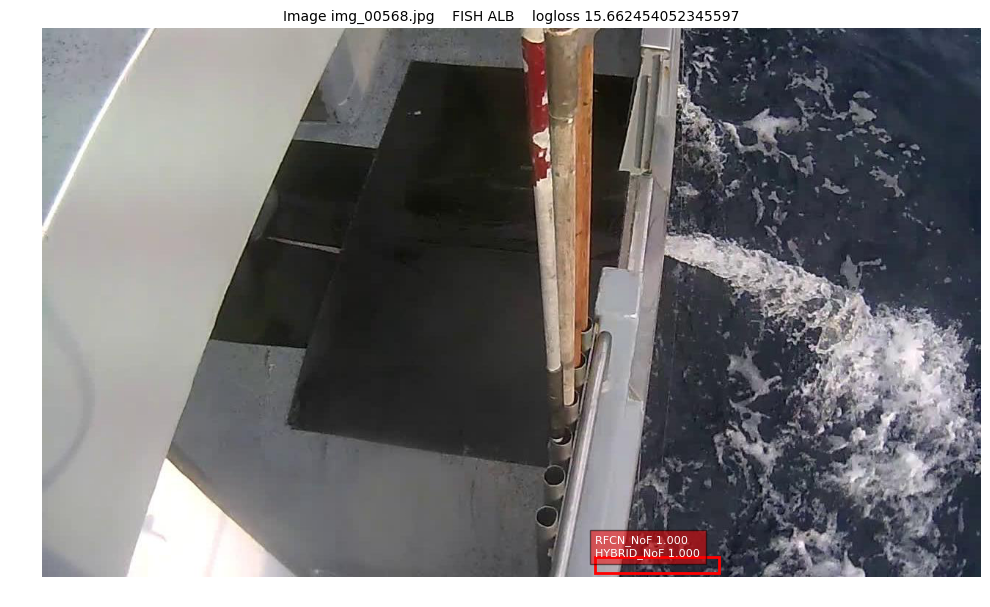

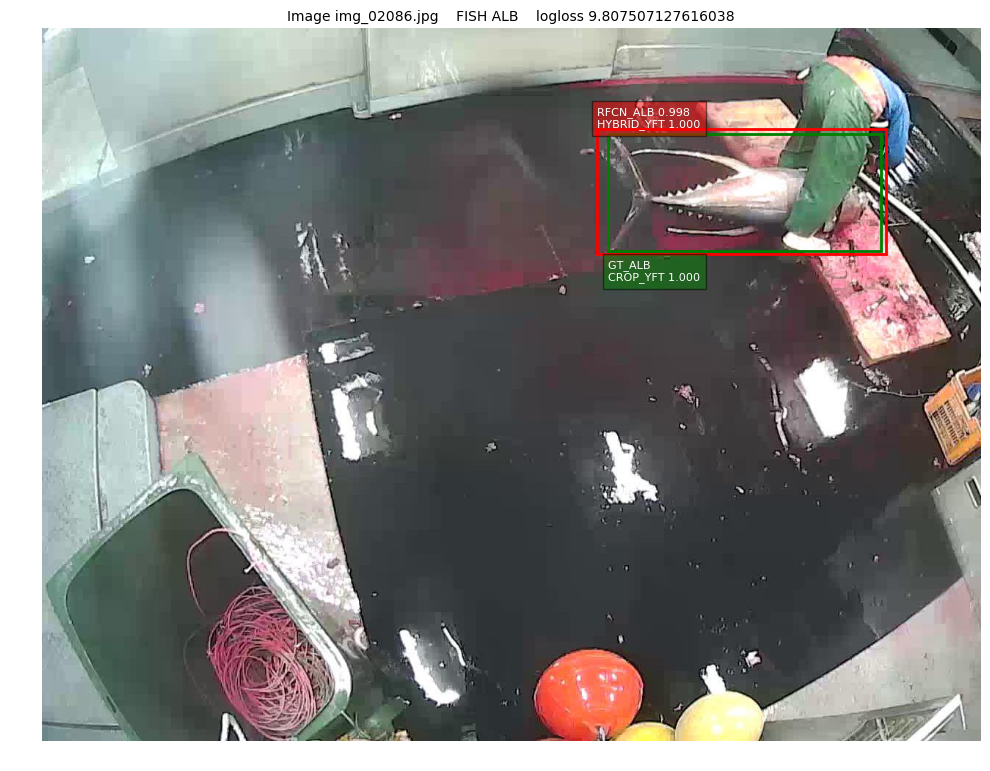

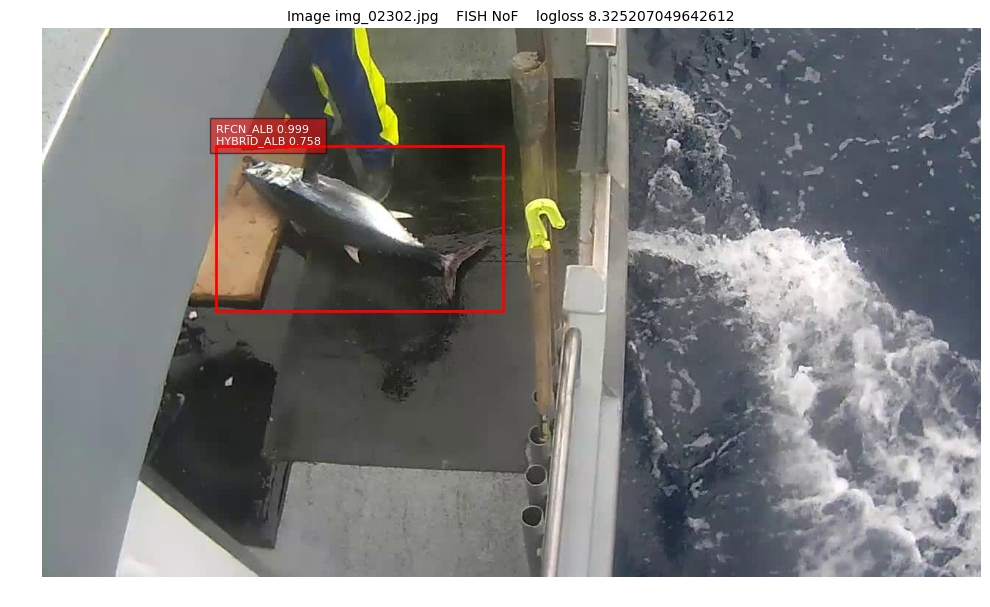

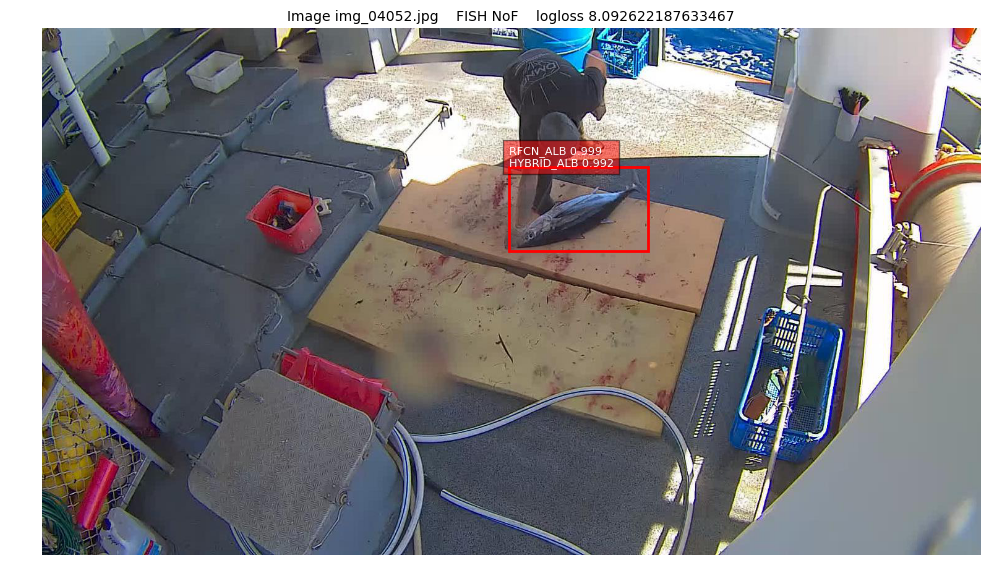

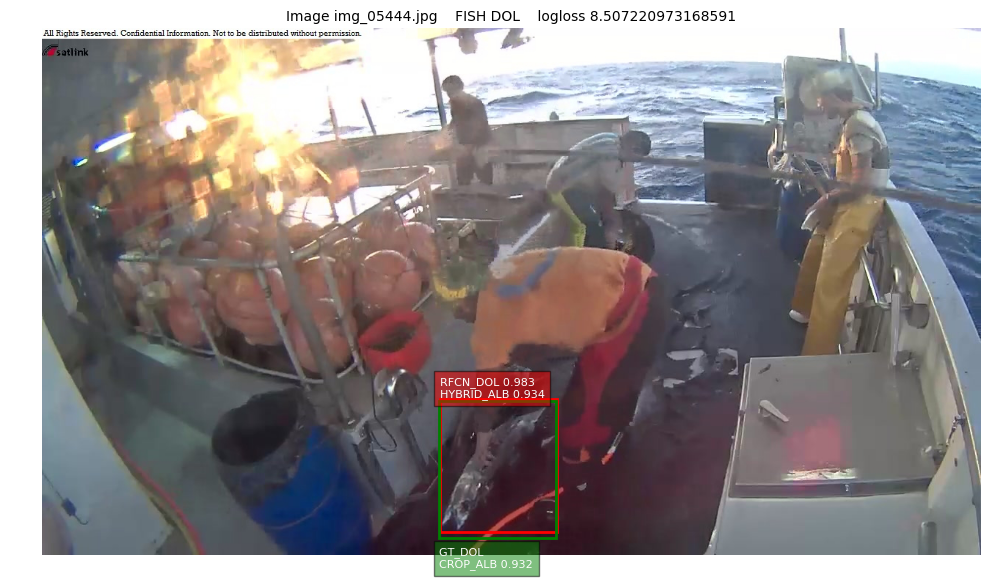

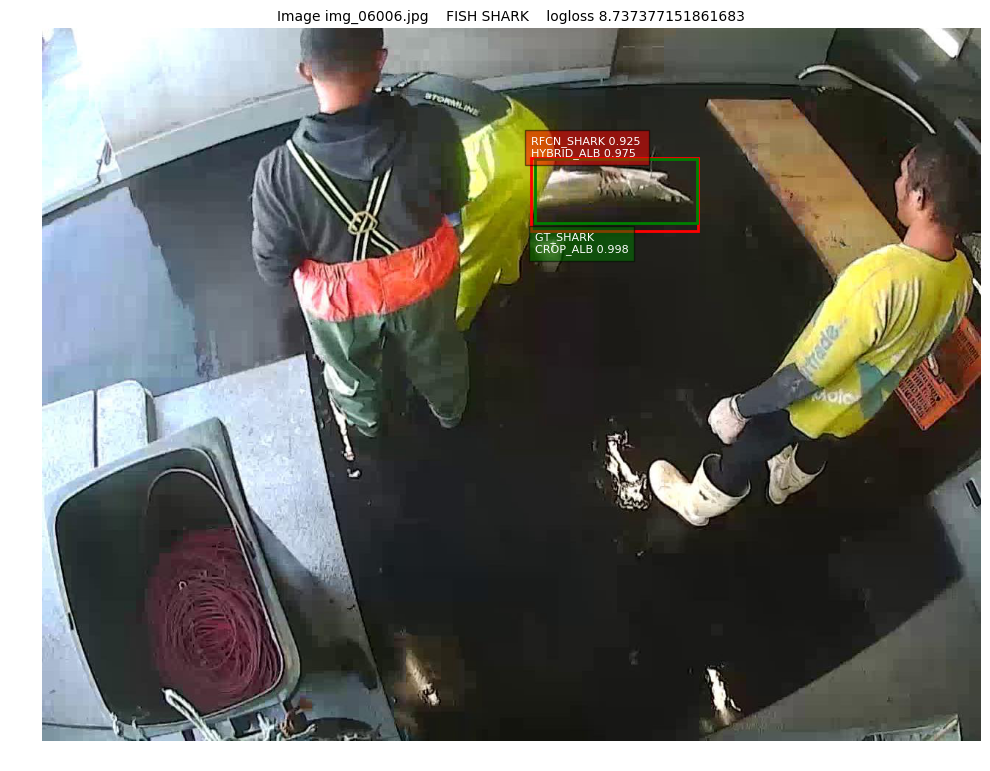

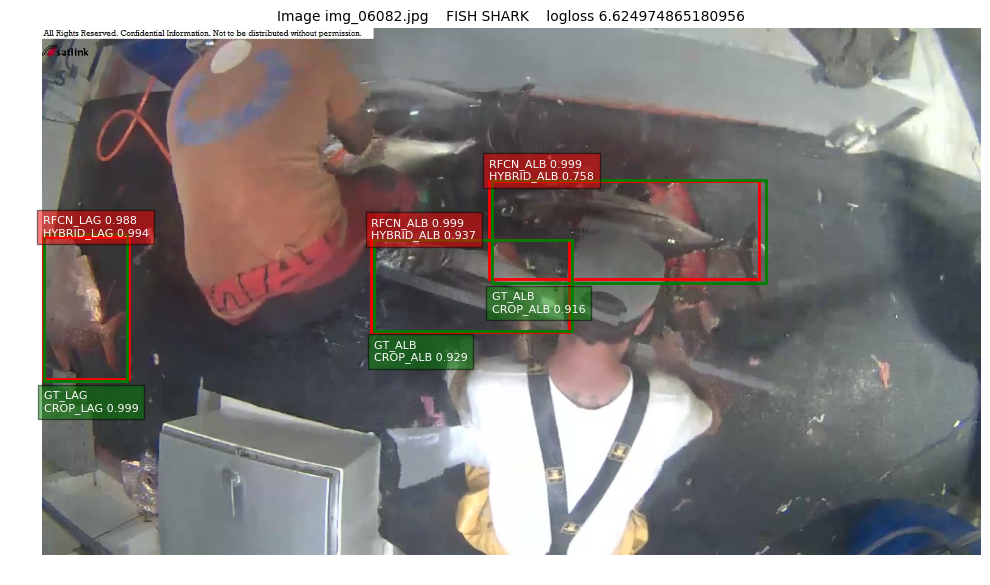

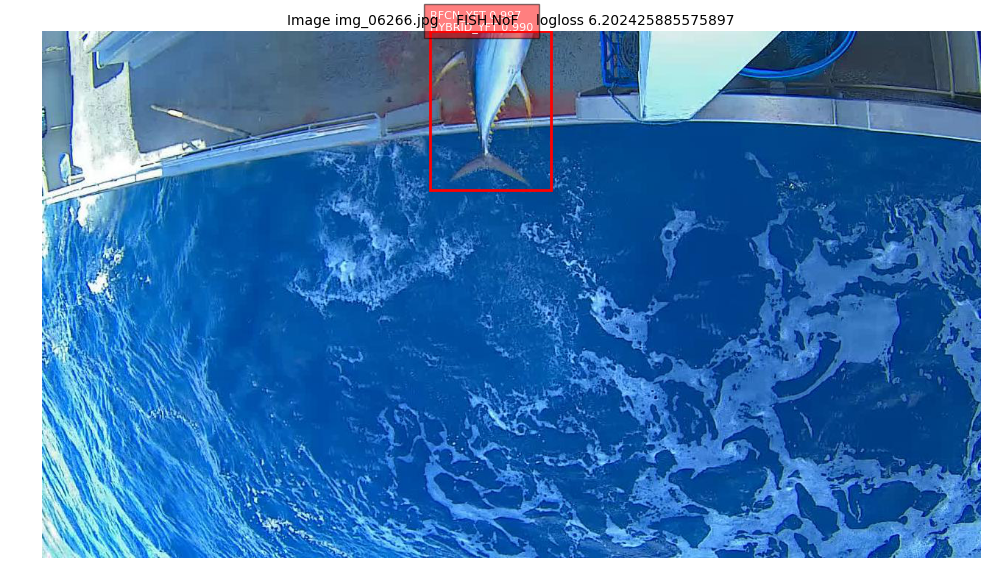

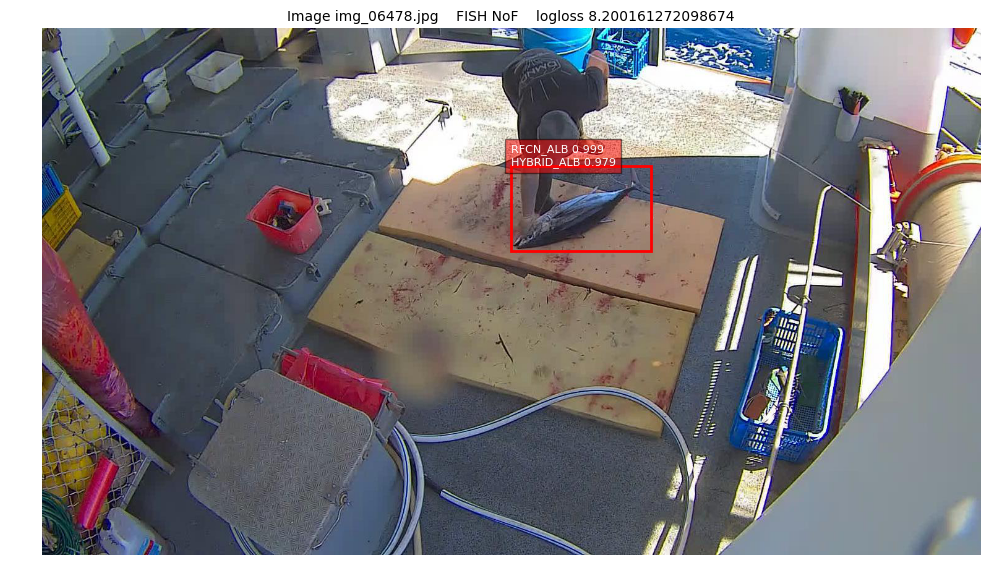

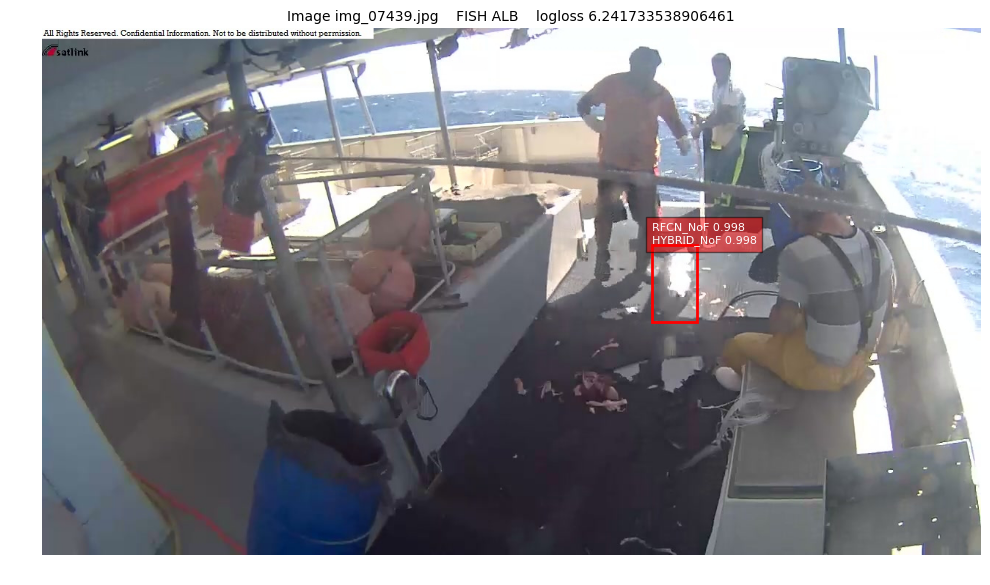

In [16]:
#### visualization
# RFCNbbox_RFCNpred_CROPpred_df = ['image_class', 'image_file','crop_index','x_min','y_min','x_max','ymax',
#                                    'NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN',
#                                    'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN'
#                                    'NoF_CROP', 'ALB_CROP', 'BET_CROP', 'DOL_CROP',
#                                    'LAG_CROP', 'OTHER_CROP', 'SHARK_CROP', 'YFT_CROP']
#GTbbox_CROPpred_df = ['image_file','crop_index','crop_class','xmin','ymin','xmax','ymax',
#                      'NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT', 'logloss']
# test_pred_df = ['logloss','image_class','image_file','NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

for j in range(test_pred_df.shape[0]):
    image_logloss = test_pred_df.iat[j,0]
    image_class = test_pred_df.iat[j,1]
    image_file = test_pred_df.iat[j,2]
    if image_logloss > 5:
        im = Image.open('../RFCN/JPEGImages/'+image_file)
        im = np.asarray(im)
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(im, aspect='equal')
        RFCN_dets = RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df.loc[RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df['image_file']==image_file]
        for index,row in RFCN_dets.iterrows():
            bbox = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
            RFCN = [row['NoF_RFCN'],row['ALB_RFCN'],row['BET_RFCN'],row['DOL_RFCN'],row['LAG_RFCN'],row['OTHER_RFCN'],row['SHARK_RFCN'],row['YFT_RFCN']]
            CROP = [row['NoF'],row['ALB'],row['BET'],row['DOL'],row['LAG'],row['OTHER'],row['SHARK'],row['YFT']]
            score_RFCN = max(RFCN)
            score_CROP = max(CROP)
            index_RFCN = RFCN.index(score_RFCN)
            index_CROP = CROP.index(score_CROP)
            class_RFCN = FISH_CLASSES[index_RFCN]
            class_CROP = FISH_CLASSES[index_CROP]
            ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, edgecolor='red', linewidth=2))
            ax.text(bbox[0], bbox[1] - 2, 'RFCN_{:s} {:.3f} \nHYBRID_{:s} {:.3f}'.format(class_RFCN, score_RFCN, class_CROP, score_CROP), bbox=dict(facecolor='red', alpha=0.5), fontsize=8, color='white')       
        GT_dets = GTbbox_CROPpred_df.loc[GTbbox_CROPpred_df['image_file']==image_file]
        for index,row in GT_dets.iterrows():
            bbox = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
            CROP = [row['ALB'],row['BET'],row['DOL'],row['LAG'],row['OTHER'],row['SHARK'],row['YFT']]
            score_CROP = max(CROP)
            index_CROP = CROP.index(score_CROP)
            class_CROP = CROP_CLASSES[index_CROP]
            ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, edgecolor='green', linewidth=2))
            ax.text(bbox[0], bbox[3] + 40, 'GT_{:s} \nCROP_{:s} {:.3f}'.format(row[2], class_CROP, score_CROP), bbox=dict(facecolor='green', alpha=0.5), fontsize=8, color='white')
        ax.set_title(('Image {:s}    FISH {:s}    logloss {}').format(image_file, image_class, image_logloss), fontsize=10) 
        plt.axis('off')
        plt.tight_layout()
        plt.draw()

In [7]:
#temperature
T = 1
test_pred_array = test_pred_df[FISH_CLASSES].values
test_pred_T_array = np.exp(np.log(test_pred_array)/T)
test_pred_T_array = test_pred_T_array/np.sum(test_pred_T_array, axis=1, keepdims=True)
test_pred_T_df = pd.DataFrame(test_pred_T_array, columns=FISH_CLASSES)
test_pred_T_df = pd.concat([test_pred_df[['image_class','image_file']],test_pred_T_df], axis=1)

#add logloss
test_pred_T_df['logloss'] = test_pred_T_df.apply(lambda row: -math.log(row[row['image_class']]) if row['image_class']!='--' else np.nan, axis=1)

#calculate train logloss
print(test_pred_T_df.groupby(['image_class'])['logloss'].mean())
train_logloss = test_pred_T_df['logloss'].mean()
print('logloss of train is', train_logloss )

image_class
--            NaN
ALB      0.061437
BET      0.048063
DOL      0.087241
LAG      0.000957
NoF      0.126442
OTHER    0.018927
SHARK    0.091090
YFT      0.033886
Name: logloss, dtype: float64
logloss of train is 0.061120628740919836


In [ ]:
#test submission
submission = test_pred_T_df.loc[:999,['image_file','NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']]
submission.rename(columns={'image_file':'image'}, inplace=True)
sub_file = 'RFCN_AGONOSTICnms_'+RFCN_MODEL+'_'+CROP_MODEL+'_clsMaxAve_conf{:.2f}_T{}_'.format(CONF_THRESH, T)+'{:.4f}'.format(train_logloss)+'.csv'
submission.to_csv(sub_file, index=False)
print('Done!'+sub_file)